In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

In [2]:
# Read the Excel file
df = pd.read_excel("./data/2021-M-BEL-Abs.xlsx", header=None, engine="openpyxl")

# Slice the DataFrame and exclude rows 43 to 50 and everything after 75
df = df.iloc[3:]
df = df[~df.index.isin(range(43, 51)) & (df.index <= 75)].reset_index(drop=True)

# Set the column names
column_names = [
    "C-Code", "Name", "Tot", "00-", "05-", "10-", "15-", "20-", "25-", "30-", "35-",
    "40-", "45-", "50-", "55-", "60-", "65-", "70-", "75-", "80-", "85+"
]
df.columns = column_names
df = df.replace('-',0)
print(df)


     C-Code                                    Name     Tot   00-   05-   10-  \
0       C00                                     Lip    33.0   0.0   0.0   0.0   
1       C01                          Base of tongue   151.0   0.0   0.0   0.0   
2       C02                                  Tongue   205.0   0.0   0.0   0.0   
3       C03                                     Gum    31.0   0.0   0.0   0.0   
4       C04                          Floor of mouth   139.0   0.0   0.0   0.0   
..      ...                                     ...     ...   ...   ...   ...   
60      C81                        Hodgkin lymphoma   197.0   0.0   1.0   5.0   
61  C82-C86                    Non-Hodgkin-lymphoma  1183.0   4.0   8.0   8.0   
62      C88  Malignant immunoproliferative diseases   238.0   0.0   0.0   1.0   
63      C90                        Multiple myeloma   569.0   0.0   0.0   0.0   
64      C91                      Lymphoid leukaemia   619.0  26.0  18.0  10.0   

    15-   20-   25-   30-  

In [3]:
# totaal maken van df voor elk jaar (tel M en V op) waar de C-code en het jaar gelijk is bij de waarden

def Load_df(f):
    current_df = pd.read_excel(f,header=None,engine="openpyxl")
    # Slice the DataFrame and exclude rows 43 to 50 and everything after 75
    current_df = current_df.iloc[3:]
    current_df = current_df[~current_df.index.isin(range(42, 51)) & (current_df.index <= 75)].reset_index(drop=True)
    # Set the column names
    column_names = [
        "C-Code", "Name", "Tot", "00-", "05-", "10-", "15-", "20-", "25-", "30-", "35-",
        "40-", "45-", "50-", "55-", "60-", "65-", "70-", "75-", "80-", "85+"
    ]
    current_df.columns = column_names
    current_df = current_df.replace('-',0)
    return current_df
    

In [132]:
# directory = './data'
# dataframes = {}

# df2016 = {}
# df2017 = {}
# df2018 = {}
# df2019 = {}
# df2020 = {}
# df2021 = {}

# for filename in os.listdir(directory):
#     file_path = os.path.join(directory,filename)
#     dataframes[filename] = Load_df(file_path)
#     tmp = filename.split("-")
#     if tmp[0] == "2016":
#         df2016[tmp[1]]= Load_df(file_path)
#     elif tmp[0] == "2017":
#         df2017[tmp[1]]= Load_df(file_path)
#     elif tmp[0] == "2018":
#         df2018[tmp[1]]= Load_df(file_path)
#     elif tmp[0] == "2019":
#         df2019[tmp[1]]= Load_df(file_path)
#     elif tmp[0] == "2020":
#         df2020[tmp[1]]= Load_df(file_path)
#     elif tmp[0] == "2021":
#         df2021[tmp[1]]= Load_df(file_path)

In [133]:
# n_c_dfM = df2016["M"].select_dtypes(include='number')
# n_c_dfF = df2016["F"].select_dtypes(include='number')
# c_n_df = n_c_dfM + n_c_dfF 
# df2016["T"] = df2016["M"].copy()
# df2016["T"][n_c_dfM.columns] = c_n_df

# n_c_dfM = df2017["M"].select_dtypes(include='number')
# n_c_dfF = df2017["F"].select_dtypes(include='number')
# c_n_df = n_c_dfM + n_c_dfF 
# df2017["T"] = df2017["M"].copy()
# df2017["T"][n_c_dfM.columns] = c_n_df

# n_c_dfM = df2018["M"].select_dtypes(include='number')
# n_c_dfF = df2018["F"].select_dtypes(include='number')
# c_n_df = n_c_dfM + n_c_dfF 
# df2018["T"] = df2018["M"].copy()
# df2018["T"][n_c_dfM.columns] = c_n_df

# n_c_dfM = df2019["M"].select_dtypes(include='number')
# n_c_dfF = df2019["F"].select_dtypes(include='number')
# c_n_df = n_c_dfM + n_c_dfF 
# df2019["T"] = df2019["M"].copy()
# df2019["T"][n_c_dfM.columns] = c_n_df

# n_c_dfM = df2020["M"].select_dtypes(include='number')
# n_c_dfF = df2020["F"].select_dtypes(include='number')
# c_n_df = n_c_dfM + n_c_dfF 
# df2020["T"] = df2020["M"].copy()
# df2020["T"][n_c_dfM.columns] = c_n_df

# n_c_dfM = df2021["M"].select_dtypes(include='number')
# n_c_dfF = df2021["F"].select_dtypes(include='number')
# c_n_df = n_c_dfM + n_c_dfF 
# df2021["T"] = df2021["M"].copy()
# df2021["T"][n_c_dfM.columns] = c_n_df

In [134]:
# print(df2020["T"])

In [4]:

def process_year_data(directory, year, dataframes):
    dfM = Load_df(os.path.join(directory, f"{year}-M-BEL-Abs.xlsx"))
    dfF = Load_df(os.path.join(directory, f"{year}-F-BEL-Abs.xlsx"))

    n_c_dfM = dfM.select_dtypes(include='number')
    n_c_dfF = dfF.select_dtypes(include='number')
    c_n_df = n_c_dfM + n_c_dfF 

    dataframes[f"{year}-T"] = dfM.copy()
    dataframes[f"{year}-T"][n_c_dfM.columns] = c_n_df

directory = './data'
dataframes = {}

years = [2016, 2017, 2018, 2019, 2020, 2021]

for year in years:
    process_year_data(directory, year, dataframes)


In [5]:
totals_per_year = {}

for year, df in dataframes.items():
    totals_per_year[year] = df['Tot'].sum()

totals_per_year


{'2016-T': 70258,
 '2017-T': 71160,
 '2018-T': 73126,
 '2019-T': 74767,
 '2020-T': 72415,
 '2021-T': 79193}

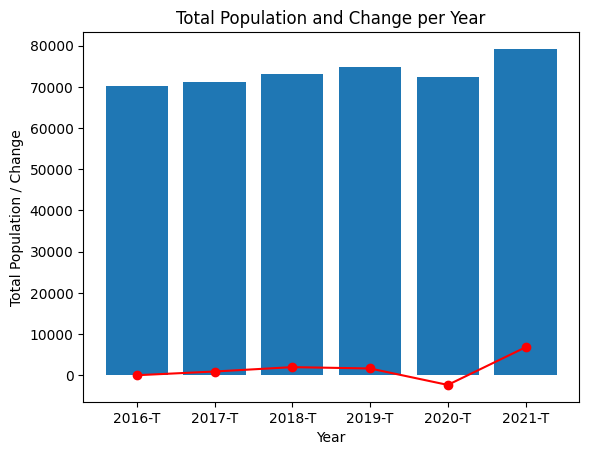

In [6]:

# Calculate the change per year
change_per_year = pd.Series(totals_per_year).diff().fillna(0)

# Create a bar plot of the totals_per_year dictionary
plt.bar(totals_per_year.keys(), totals_per_year.values())

# Create a line plot of the change_per_year
plt.plot(change_per_year.keys(), change_per_year.values, color='red', marker='o')

# Set the title and labels
plt.title('Total Population and Change per Year')
plt.xlabel('Year')
plt.ylabel('Total Population / Change')

# Show the plot
plt.show()


If you look at the red line, you can see that there was always an increase in the number of diagnosed cancers until 2019. However, this growth stopped in 2019 and 2020 (even turned negative). This can be explained by the COVID-19 crisis, where people had less access to healthcare and were less likely to get tested.
The spike in 2021 can partly be explained due to the backlog of people geting there diagnosis


## Waterkwaliteid over dezelfde jaren

Om

In [23]:
import os
import pandas as pd

directory = "./PFAS_data"
dataframes = []

for filename in os.listdir(directory):
    if filename.endswith(".xlsx"):
        file_path = os.path.join(directory, filename)
        xls = pd.ExcelFile(file_path)
        for sheet_name in xls.sheet_names:
            if sheet_name == 'Resultaat':
                df = pd.read_excel(xls, sheet_name)
                dataframes.append(df)


In [41]:
dataframes[0]['Symbool'] == "PFOS vertakt"

0        False
1        False
2        False
3        False
4        False
         ...  
12135    False
12136    False
12137    False
12138    False
12139    False
Name: Symbool, Length: 12140, dtype: bool

In [43]:
filtered_rows = []
for i in range(len(dataframes)-1):
    for row in dataframes[i]:
        print(row)
        # if (row['Symbool'] == 'PFOS vertakt'):
        #     filtered_rows.append(row)



Punt Nummer
Waterloop
Gemeente
Provincie
Bekken
Lambert X
Lambert Y
Jaar
Type
Parameter ID
Symbool
Parameter
Dag
Teken
Resultaat
Eenheid
Punt Nummer
Waterloop
Gemeente
Provincie
Bekken
Lambert X
Lambert Y
Jaar
Type
Parameter ID
Symbool
Parameter
Dag
Teken
Resultaat
Eenheid
Punt Nummer
Waterloop
Gemeente
Provincie
Bekken
Lambert X
Lambert Y
Jaar
Type
Parameter ID
Symbool
Parameter
Dag
Teken
Resultaat
Eenheid
Punt Nummer
Waterloop
Gemeente
Provincie
Bekken
Lambert X
Lambert Y
Jaar
Type
Parameter ID
Symbool
Parameter
Dag
Teken
Resultaat
Eenheid
Punt Nummer
Waterloop
Gemeente
Provincie
Bekken
Lambert X
Lambert Y
Jaar
Type
Parameter ID
Symbool
Parameter
Dag
Teken
Resultaat
Eenheid
Punt Nummer
Waterloop
Gemeente
Provincie
Bekken
Lambert X
Lambert Y
Jaar
Type
Parameter ID
Symbool
Parameter
Dag
Teken
Resultaat
Eenheid
Punt Nummer
Waterloop
Gemeente
Provincie
Bekken
Lambert X
Lambert Y
Jaar
Type
Parameter ID
Symbool
Parameter
Dag
Teken
Resultaat
Eenheid
[]
